In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

annot1 = pd.read_parquet('annotations_round_1.parquet')

quality_labels = annot1.quality_label.str.strip('[]').str.split('; ')
mlb = MultiLabelBinarizer()
df_transformed = pd.DataFrame(mlb.fit_transform(quality_labels), 
                              columns=mlb.classes_, 
                              index=annot1.index)
annot1 = annot1.join(df_transformed)

annot2 = pd.read_parquet('annotations_round_2.parquet')

In [9]:
indices = set(annot1.original_index)
assert len(indices) == 10042
assert indices == set(range(10042))

Toxicity

In [10]:
toxicity_rows = set(range(10042)) - set(annot2.original_index)
toxicity_rows

{3648, 3760, 4307, 7001, 7423, 8135}

In [11]:
new_indices = indices - toxicity_rows
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 6 left: 10036


Annot1: nonsense or ungrammatical prompts

In [12]:
bad_prompt = set(annot1[(annot1['nonsense, prompt'] + annot1['ungrammatical, prompt']) > 0].original_index)
len(bad_prompt)

4065

In [13]:
new_indices = indices - bad_prompt
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 4064 left: 5972


Annot1: nonsense or ungrammatical correct answer

In [14]:
bad_correct = set(annot1[(annot1['nonsense, correct answer'] + annot1['ungrammatical, correct answer']) > 0].original_index)
len(bad_correct)

711

In [15]:
new_indices = indices - bad_correct
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 191 left: 5781


Annot1: ungrammatical incorrect answers

In [16]:
bad_incorrect = set(annot1[(annot1['ungrammatical, incorrect answer(s)']) > 0].original_index)
len(bad_incorrect)

3959

In [17]:
new_indices = indices - bad_incorrect
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 1975 left: 3806


Annot2: wrong answer

In [18]:
wrong_answer = set(annot2[annot2['best_option'].apply(lambda x: 'ABCD'.index(x)) != annot2['Correct Answer'].astype(int)].original_index)
len(wrong_answer)

370

In [19]:
new_indices = indices - wrong_answer
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 89 left: 3717


Annot2: all nonsense

In [20]:
all_nonsense = set(annot2[annot2.all_implausible == 'Yes'].original_index)
len(all_nonsense)

409

In [21]:
new_indices = indices - all_nonsense
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 23 left: 3694


Annot2: multiple correct

In [22]:
multiple_correct = set(annot2[annot2.equally_good_options != 'None'].original_index)
len(multiple_correct)

2121

In [23]:
new_indices = indices - multiple_correct
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 583 left: 3111


Annot2: correct is worst

In [24]:
correct_is_worst = set(annot2[annot2['worst_option'].apply(lambda x: 'ABCD'.index(x)) == annot2['Correct Answer'].astype(int)].original_index)
len(correct_is_worst)

13

In [25]:
new_indices = indices - correct_is_worst
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 0 left: 3111


token lengths: relative length > 0.3

In [27]:
from transformers import AutoTokenizer

model_name = 'meta-llama/Llama-3.2-1B'

tokenizer = AutoTokenizer.from_pretrained(model_name)

scores = pd.read_csv(f"data/log_likelihood/full_prompt/{model_name.replace('/', '--')}.csv")
annot1_len = annot1.join(scores)

for i in range(4):
    annot1_len[f'option_{i}'] = annot1_len.Options.str.split('\n').apply(lambda x: x[i][3:].replace(' (Labeled as correct)', ''))

lengths = pd.concat([
    annot1_len[['Question', f'option_{i}', f'nll_{i}']].rename(columns={
        f'option_{i}': 'option',
        f'nll_{i}': 'Mean Log-Likelihood',
    }) for i in range(4)
])

lengths['Text Length'] = lengths.apply(lambda row: len(tokenizer.encode(row['Question'] + row['option'])), axis=1)

result = lengths.groupby(lengths.index)['Text Length'].agg(lambda x: x.max() - x.min())
result = result.rename('Length Difference')
result /= lengths.groupby(lengths.index)['Text Length'].max()

In [28]:
diff_lengths = set(annot1[(result > 0.3)].original_index)
len(diff_lengths)

802

In [29]:
new_indices = indices - diff_lengths
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 96 left: 3015


token lengths: diff > 0.15 and longest is correct

In [30]:
annot1_len['longest'] = annot1_len[[f'option_{i}' for i in range(4)]].apply(lambda row: np.argmax([len(tokenizer.encode(o)) for o in row]), axis=1)

In [31]:
longest_is_correct = set(annot1[(result > 0.15) & (result <= 0.3) & (annot1_len.longest == annot1_len['Correct Answer'].astype(int))].original_index)
len(longest_is_correct)

1270

In [32]:
new_indices = indices - longest_is_correct
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 414 left: 2601


zero-prompt core

In [33]:
def get_complete_dataframe(model_name):
    df = pd.read_parquet('annotations_round_1.parquet')
    scores = pd.read_csv('data/log_likelihood/full_prompt/' + model_name)
    predictions = scores.to_numpy().argmax(axis=1)
    scores_answer = pd.read_csv('data/log_likelihood/zero_prompt/' + model_name)
    predictions_answer = scores_answer.to_numpy().argmax(axis=1)
    return pd.DataFrame({
        'Full Prompt': predictions,
        'Zero Prompt': predictions_answer,
        'Correct Answer': df['Correct Answer'].astype(int),
    })


def same_correct_map(model_name):
    df = get_complete_dataframe(model_name)
    same_correct = (df['Zero Prompt'] == df['Correct Answer'])
    return same_correct.astype(int)

In [34]:
models = ['qwen-2.5-32b-instruct.csv', 'OLMo-2-0325-32B-Instruct.csv', 'meta-llama--Llama-3.2-1B.csv', 'google--gemma-3-1b-pt.csv', 'Qwen--Qwen2.5-1.5B.csv', 'HuggingFaceTB--SmolLM2-1.7B.csv', 'ibm-granite--granite-3.1-1b-a400m-base.csv', 'EleutherAI--pythia-1b.csv', 'PleIAs--Pleias-1b-Preview.csv', 'deepseek-ai--DeepSeek-R1-Distill-Qwen-1.5B.csv']

same_correct = same_correct_map(models[0])
for model in models[1:]:
    same_correct += same_correct_map(model)

same_correct.value_counts()

0     2501
10    1805
9      913
1      838
2      690
8      656
7      589
6      547
3      510
4      501
5      492
Name: count, dtype: int64

In [35]:
cumul = 0
result = []
for i in range(10):
    cumul += same_correct.value_counts()[10-i]
    result.append(cumul)

for r in reversed(result):
    print(f'{r / 10042 * 100:.0f}', end='\% & ')

75\% & 67\% & 60\% & 55\% & 50\% & 45\% & 39\% & 34\% & 27\% & 18\% & 

In [36]:
same_correct_id = set(annot1[(same_correct > 6)].original_index)
len(same_correct_id)

3963

In [37]:
new_indices = indices - same_correct_id
print('removed:', len(indices) - len(new_indices), 'left:', len(new_indices))
indices = new_indices

removed: 1076 left: 1525


In [38]:
len(indices) / 10042

0.1518621788488349

In [39]:
model_map = {
    'EleutherAI--pythia-1b.csv': 'Pythia 1B',
    'HuggingFaceTB--SmolLM2-1.7B.csv': 'SmolLM2 1.7B',
    'PleIAs--Pleias-1b-Preview.csv': 'PleIAs 1.0 1B',
    'Qwen--Qwen2.5-1.5B.csv': 'Qwen 2.5 1.5B',
    'deepseek-ai--DeepSeek-R1-Distill-Qwen-1.5B.csv': 'DeepSeek-R1 1.5B',
    'google--gemma-3-1b-pt.csv': 'Gemma 3 1B',
    'ibm-granite--granite-3.1-1b-a400m-base.csv': 'Granite 3.1 1B',
    'meta-llama--Llama-3.2-1B.csv': 'Llama 3.2 1B',
    'qwen-2.5-32b-instruct.csv': 'Qwen 2.5 32B',
    'OLMo-2-0325-32B-Instruct.csv': 'OLMo 2 32B'
}

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Palatino'
sns.set_context("paper", font_scale=2.1)

In [40]:
golden_swag = annot2.loc[annot2.original_index.apply(lambda x: x in indices)]

In [45]:
def compute_accuracy_(model_name, data):
    scores = pd.read_csv('data/log_likelihood/full_prompt/' + model_name).iloc[data.original_index]
    predictions = scores.to_numpy().argmax(axis=1)
    scores_answer = pd.read_csv('data/log_likelihood/zero_prompt/' + model_name).iloc[data.original_index]
    predictions_answer = scores_answer.to_numpy().argmax(axis=1)
    gold_best = data['Correct Answer'].astype(int)
    
    accuracy = (predictions == gold_best).mean()
    accuracy_answer = (predictions_answer == gold_best).mean()
    return accuracy, accuracy_answer

def compute_accuracy(model_name):
    res1 = compute_accuracy_(model_name, annot2)
    res2 = compute_accuracy_(model_name, golden_swag)
    return res1[0], res2[0], res1[1], res2[1]

In [46]:
accuracy_types = ["HellaSwag", "GoldenSwag"]
evaluation_types = ["Full-Prompt", "Zero-Prompt"]

data = []

for model in models:
    accuracies = compute_accuracy(model)
    for i, eval_type in enumerate(evaluation_types):
        for j, acc_type in enumerate(accuracy_types):
            data.append([model_map[model], eval_type, acc_type, accuracies[i * 2 + j]])

df = pd.DataFrame(data, columns=["Model", "Evaluation Type", "Accuracy Type", "Value"])

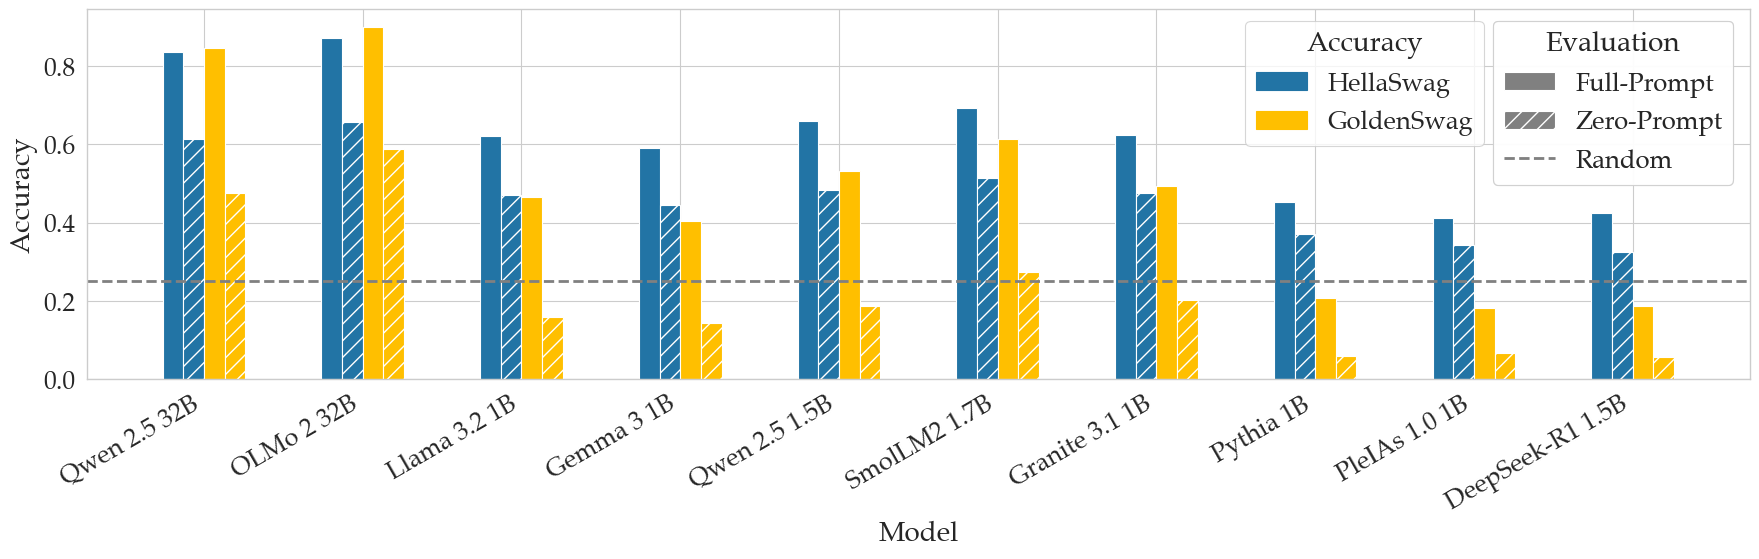

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors = ["#2274A5", '#FFBF00']

hatches = ['', '//']

plt.figure(figsize=(18, 6))

bar_width = 0.13
x = np.arange(len(models))

for i, accuracy_type in enumerate(accuracy_types):
    for j, eval_type in enumerate(evaluation_types):
        values = df[(df['Accuracy Type'] == accuracy_type) & (df['Evaluation Type'] == eval_type)]
        position_offset = (i * len(evaluation_types) + j) * bar_width
        plt.bar(x + position_offset, values['Value'], width=bar_width,
                color=colors[i], hatch=hatches[j], label=f'Acc {accuracy_type}, Eval {eval_type}' if i == 0 and j == 0 else "")

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(x + (len(accuracy_types) * len(evaluation_types) * bar_width / 2) - (bar_width / 2), [model_map[m] for m in models], rotation=30, ha="right")
plt.axhline(0.25, linestyle='--', linewidth=2, color='gray', label='random')

color_patches = [mpatches.Patch(color=colors[i], label=t) for i, t in enumerate(accuracy_types)]
hatch_patches = [mpatches.Patch(facecolor='gray', hatch=hatches[i], label=t) for i, t in enumerate(evaluation_types)]
baseline_line = plt.Line2D([0], [0], color='gray', linestyle='--', label='Random', linewidth=2) 

legend1 = plt.legend(handles=color_patches, title='Accuracy', bbox_to_anchor=(0.84, 0.97), loc='upper right', borderaxespad=0.)
legend2 = plt.legend(handles=hatch_patches + [baseline_line], title='Evaluation', bbox_to_anchor=(0.99, 0.97), loc='upper right', borderaxespad=0.)

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2) 

plt.tight_layout()
plt.show()

In [ ]:
from datasets import load_dataset

dataset = load_dataset("hellaswag")['validation']

In [52]:
golden_swag_hf = dataset.select(indices)

In [53]:
golden_swag_hf

Dataset({
    features: ['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'endings', 'source_id', 'split', 'split_type', 'label'],
    num_rows: 1525
})

In [54]:
golden_swag_hf.to_parquet('goldenswag.parquet')

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

2034111